In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [2]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')

In [3]:
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,01/03/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,01/04/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,01/05/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,01/06/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,01/09/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
#keras only takes numpy array
training_set = dataset_train.iloc[:, 1: 2].values

In [6]:
training_set.shape

(1509, 1)

In [7]:
sc = MinMaxScaler(feature_range = (0, 1))
#fit: get min/max of train data
training_set_scaled = sc.fit_transform(training_set)

In [8]:
## 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])   # Each sample in X_train contains 60 previous stock prices, and the corresponding y_train value is the next day's stock price
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
X_train.shape

(1449, 60)

In [10]:
y_train.shape

(1449,)

In [34]:
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))

# LSTM models in Keras expect input data to have a specific shape. The shape of the input data for an LSTM model should be in the format [batch_size, time_steps, input_dim], where:
# batch_size refers to the number of samples or sequences in each batch.
# time_steps refers to the number of time steps or past observations included in each input sample.
# input_dim refers to the number of features or variables in each time step

In [35]:
X_train.shape

(1449, 60, 1)

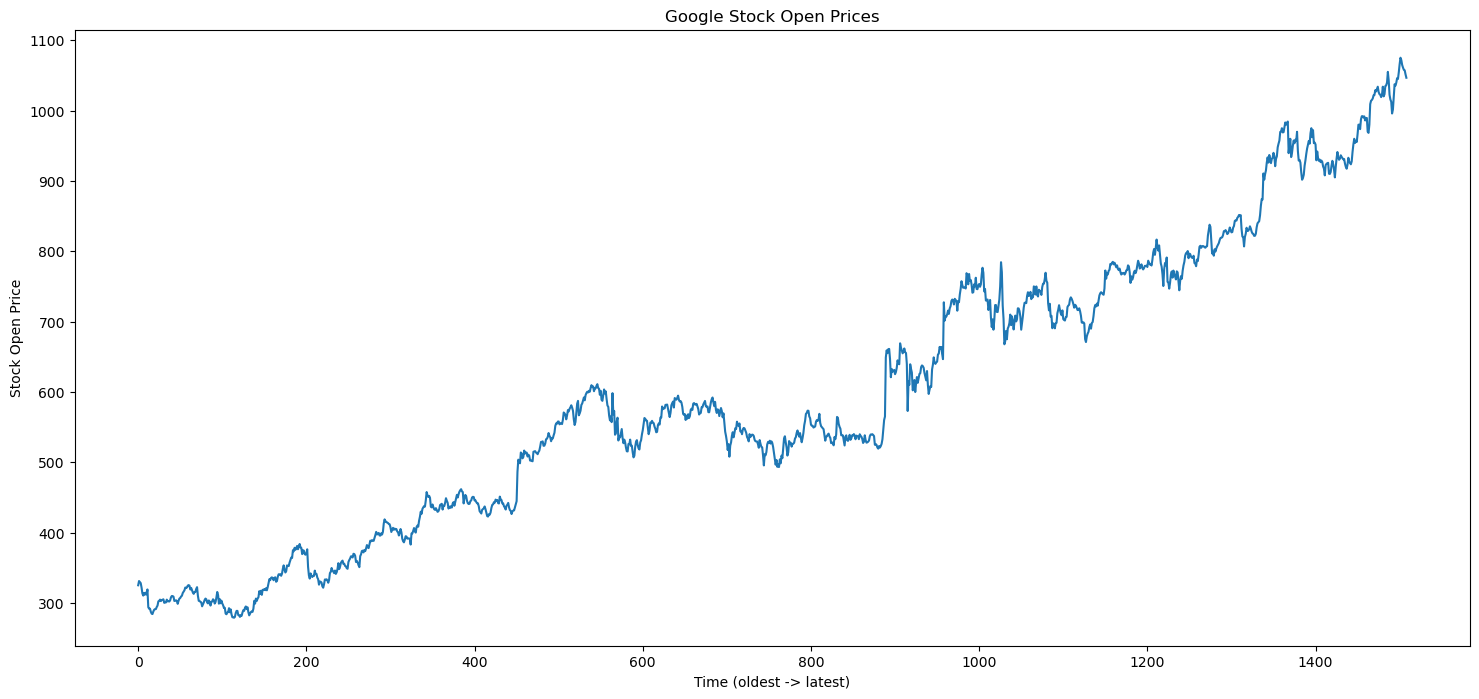

In [13]:
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Open'])
plt.title("Google Stock Open Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Open Price")
plt.show()

In [14]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))

In [15]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [16]:
    regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)

Epoch 1/100
46/46 [==============================] - 10s 62ms/step - loss: 0.0315
Epoch 2/100
46/46 [==============================] - 3s 66ms/step - loss: 0.0042
Epoch 3/100
46/46 [==============================] - 3s 67ms/step - loss: 0.0034
Epoch 4/100
46/46 [==============================] - 3s 66ms/step - loss: 0.0033
Epoch 5/100
46/46 [==============================] - 3s 65ms/step - loss: 0.0032
Epoch 6/100
46/46 [==============================] - 3s 64ms/step - loss: 0.0034
Epoch 7/100
46/46 [==============================] - 3s 65ms/step - loss: 0.0030
Epoch 8/100
46/46 [==============================] - 3s 65ms/step - loss: 0.0025
Epoch 9/100
46/46 [==============================] - 3s 64ms/step - loss: 0.0030
Epoch 10/100
46/46 [==============================] - 3s 63ms/step - loss: 0.0028
Epoch 11/100
46/46 [==============================] - 3s 64ms/step - loss: 0.0029
Epoch 12/100
46/46 [==============================] - 3s 63ms/step - loss: 0.0029
Epoch 13/100
46/46 [====

46/46 [==============================] - 3s 65ms/step - loss: 9.8836e-04


In [17]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')

In [18]:
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,02/01/2018,1048.339966,1066.939941,1045.229980,1065.000000,1237600
1,03/01/2018,1064.310059,1086.290039,1063.209961,1082.479980,1430200
2,04/01/2018,1088.000000,1093.569946,1084.001953,1086.400024,1004600
3,05/01/2018,1094.000000,1104.250000,1092.000000,1102.229980,1279100
4,08/01/2018,1102.229980,1111.270020,1101.619995,1106.939941,1047600


In [19]:
#keras only takes numpy array
real_stock_price = dataset_test.iloc[:, 1: 2].values
real_stock_price.shape

(125, 1)

In [20]:
#vertical concat use 0, horizontal uses 1
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), 
                          axis = 0)
##use .values to make numpy array
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

In [21]:
#reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)

#scale input
inputs = sc.transform(inputs)

In [22]:
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#add dimension of indicator
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [23]:
X_test.shape

(125, 60, 1)

In [24]:
predicted_stock_price = regressor.predict(X_test)

4/4 [==============================] - 1s 21ms/step


In [25]:
#inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

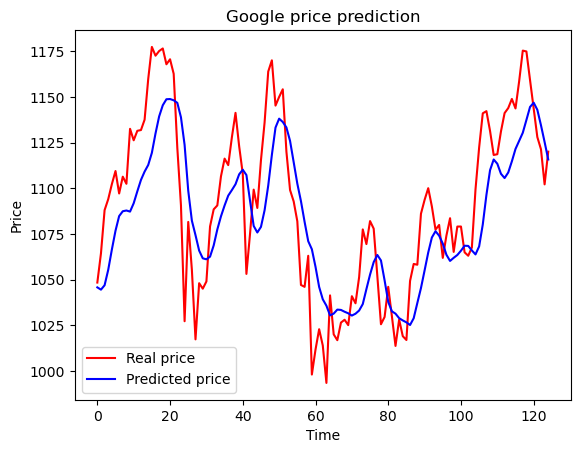

In [26]:
##visualize the prediction and real price
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')

plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()